In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Data Acquisition
Flat acquisition, i dati sono già disponibili online da: grouplens.org

In [2]:
# Flat acquisition from csv files
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')
genome_score = pd.read_csv('data/genome-scores.csv')
genome_tags = pd.read_csv('data/genome-tags.csv')

In [3]:
# Displaying the first 5 rows of each dataset
print("Movies.csv")
display(movies.head())
print("Ratings.csv")
display(ratings.head())
print("Tags.csv")
display(tags.head())
print("Genome-scores.csv")
display(genome_score.head())
print("Genome-tags.csv")
display(genome_tags.head())

Movies.csv


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Ratings.csv


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Tags.csv


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


Genome-scores.csv


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


Genome-tags.csv


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


- <b>Movies:</b> contiene id, titolo e genere di ogni film
- <b>Ratings:</b> contiene tutti i ratings associati per ogni film da ogni utente
- <b>Tags:</b> contiene tutti i tag associati per ogni film da ogni utente
- <b>Genome-scores:</b> contiene per ogni tag associato ad un film la sua rilevanza
- <b>Genome-tags:</b> contiene per ogni tag il suo id e il suo nome

"link.csv" non utile ai fini dello studio

# Data Wrangling
Manipolazione dei dati per renderli più adatti all'analisi

In [4]:
ratings_cpy = ratings.copy()  # per data visual

# Raggruppamento dei ratings per film per media e count
ratings = ratings.groupby('movieId').agg({'rating': ['mean', 'count'], 'timestamp': ['mean']})

ratings.columns = ['rating_mean', 'rating_count', 'timestamp_mean']

# Rimozione della colonna timestamp_mean non più utile
ratings = ratings.drop('timestamp_mean', axis=1)

ratings.reset_index()
print("Ratings:")
display(ratings.head())

Ratings:


,rating_mean,rating_count
movieId,,
1,3.893708,57309
2,3.251527,24228
3,3.142028,11804
4,2.853547,2523
5,3.058434,11714


In [5]:
# Divisione dei generi dei film in colonne
genres = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres = pd.DataFrame(genres, columns=['genre'])

movies = movies.join(movies.genres.str.get_dummies().astype(int))
movies.drop('genres', inplace=True, axis=1)


In [6]:
# Estrazione dell'anno di pubblicazione del film dalla colonna title
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year
movies.title = movies.title.str[:-7]

print("Movies:")
display(movies.head())

Movies:


,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1995.0
1,2,Jumanji,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995.0
2,3,Grumpier Old Men,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1995.0
3,4,Waiting to Exhale,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1995.0
4,5,Father of the Bride Part II,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1995.0


In [7]:
# Merging all togheter
df = movies.merge(genome_score, on='movieId')

df = df.merge(genome_tags, on='tagId')

df = df.pivot_table(index=['movieId', 'title', 'year'], columns='tag', values='relevance')

df = ratings.merge(df, on='movieId')

# Dataframe without genres
df_no_genres = df.copy()

#Generi
df = df.merge(movies, on='movieId')

display(df.head())

,movieId,rating_mean,rating_count,007,007 (series),18th century,1920s,1930s,1950s,1960s,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,3.893708,57309,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,...,0,0,0,0,0,0,0,0,0,1995.0
1,2,3.251527,24228,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,...,0,0,0,0,0,0,0,0,0,1995.0
2,3,3.142028,11804,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,...,0,0,0,0,1,0,0,0,0,1995.0
3,4,2.853547,2523,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,...,0,0,0,0,1,0,0,0,0,1995.0
4,5,3.058434,11714,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,...,0,0,0,0,0,0,0,0,0,1995.0


### Data Cleaning
Pulizia dei dati da eventuali valori nulli

In [8]:
print("Number of rows: ", df.shape[0])
df = df.fillna(0)
print("Number of rows after cleaning: ", df.shape[0])
print("Number of duplicates: ", df.duplicated().sum())

Number of rows:  13798
Number of rows after cleaning:  13798
Number of duplicates:  0


# Data Visualization
Visualizzazione dei dati per capire meglio le relazioni tra di essi

In [9]:
print(f'Number of samples: {df.shape[0]}')
df.describe()

Number of samples: 13798


,movieId,rating_mean,rating_count,007,007 (series),18th century,1920s,1930s,1950s,1960s,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
count,13798.000000,13798.000000,13798.000000,13798.000000,13798.000000,13798.000000,13798.000000,13798.000000,13798.000000,13798.000000,...,13798.000000,13798.000000,13798.000000,13798.000000,13798.000000,13798.000000,13798.000000,13798.000000,13798.000000,13798.000000
mean,45856.606972,3.271746,1787.492680,0.046602,0.044776,0.078277,0.085590,0.129271,0.088343,0.074097,...,0.107914,0.012538,0.035585,0.059139,0.157776,0.086679,0.192202,0.040948,0.019713,1994.397956
std,55195.887374,0.483867,4883.318028,0.071520,0.062635,0.111632,0.086057,0.146725,0.105217,0.100439,...,0.310283,0.111273,0.185259,0.235893,0.364545,0.281375,0.394045,0.198177,0.139017,19.782670
min,1.000000,0.899038,33.000000,0.007000,0.007250,0.006000,0.010000,0.017250,0.004250,0.004500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1896.000000
25%,3849.250000,2.986460,98.250000,0.025750,0.026750,0.028750,0.037250,0.053250,0.029500,0.024500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1986.000000
50%,8536.000000,3.339613,288.000000,0.033750,0.034750,0.042000,0.056000,0.078250,0.052750,0.041500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2000.000000
75%,79896.500000,3.629308,1158.000000,0.045250,0.047250,0.079500,0.102187,0.136000,0.101437,0.078750,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2009.000000
max,206499.000000,4.483096,81491.000000,0.999750,1.000000,0.997750,0.922000,0.988000,0.920000,0.913500,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2019.000000


### Number of movies and ratings per year

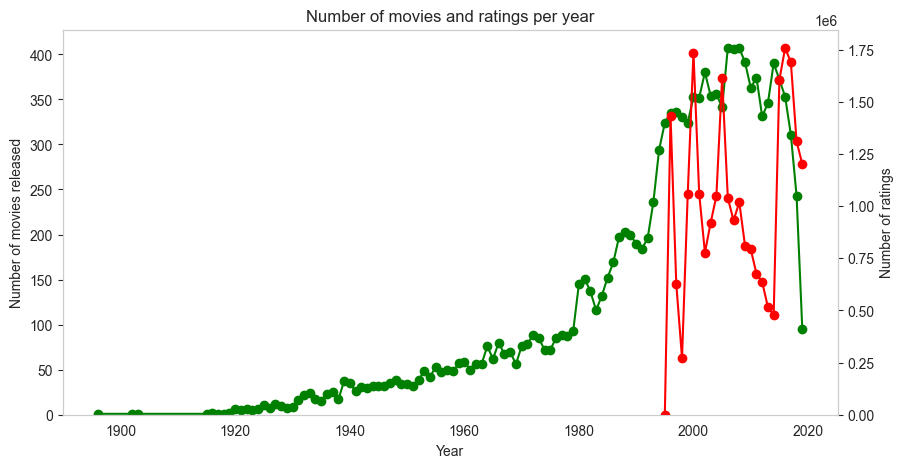

In [10]:
# Non so se ha senso
# Temporary dataframe for counting movies and ratings per year
dftmp = df[['movieId', 'year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(dftmp.year.first(), dftmp.movieId.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0, )

ratings_cpy.timestamp = pd.to_datetime(ratings_cpy.timestamp, unit='s')
ratings_cpy.timestamp = ratings_cpy.timestamp.dt.year
ratings_cpy.sort_values(by='movieId', inplace=True)
ratings_cpy.reset_index(inplace=True, drop=True)

dftmp = ratings_cpy[['rating', 'timestamp']].groupby('timestamp')
ax2 = ax1.twinx()
ax2.plot(dftmp.timestamp.first(), dftmp.rating.count(), "r-o")
ax2.grid(None)
ax2.set_ylim(0, )

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of movies released')
ax2.set_ylabel('Number of ratings')
plt.title('Number of movies and ratings per year')
# da sistemare
plt.show()

### Distribution of ratings

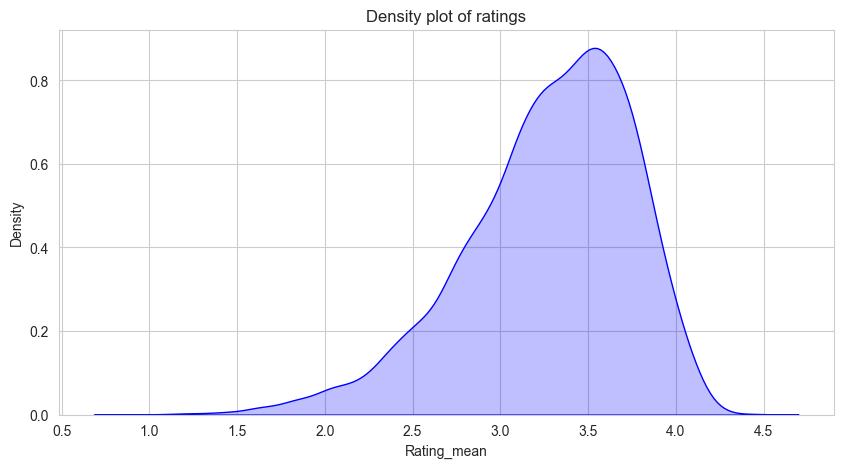

In [23]:
# Density plot of Ratings
plt.figure(figsize=(10, 5))
sns.kdeplot(df.rating_mean, fill=True, color='blue')
plt.title('Density plot of ratings')
plt.xlabel('Rating_mean')
plt.show()

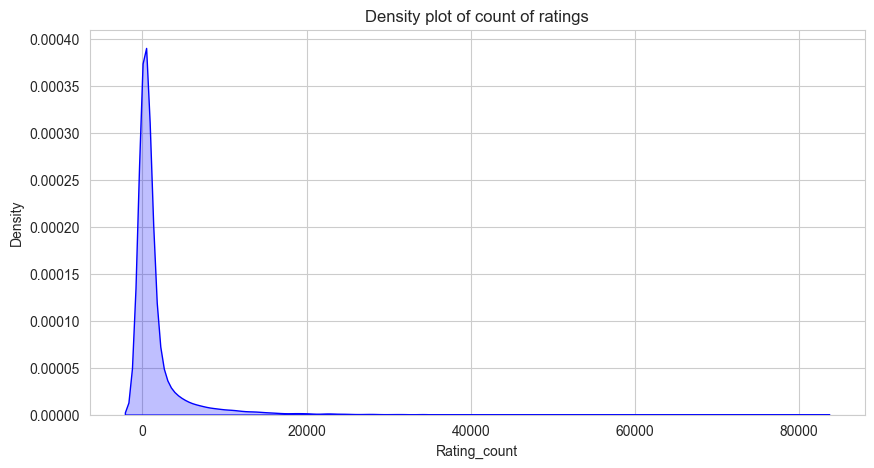

In [12]:
# Density plot of count of ratings
plt.figure(figsize=(10, 5))
sns.kdeplot(df.rating_count, fill=True, color='blue')
plt.title('Density plot of count of ratings')
plt.xlabel('Rating_count')
plt.show()

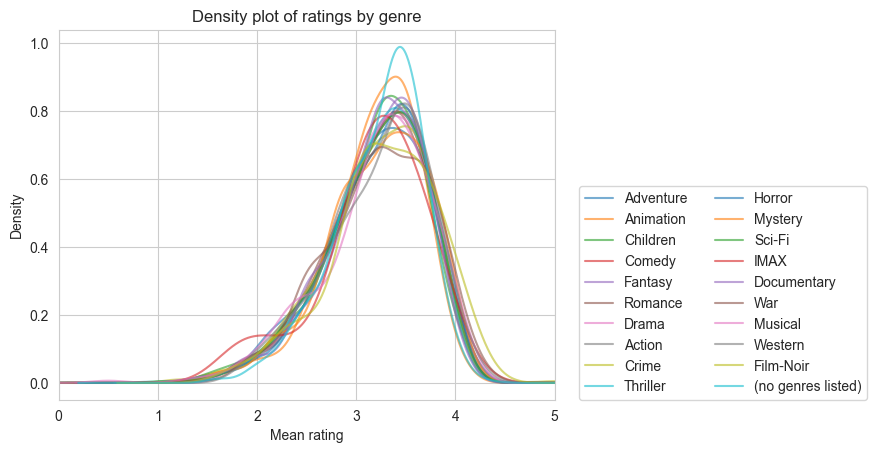

In [13]:
# Density plot of ratings by genre
dftmp = df[['movieId', 'rating_mean']].groupby('movieId').mean()

for genre in genres.genre:
    dftmp = movies[movies[genre] == True]
    dftmp = ratings[ratings.index.isin(dftmp.index)]
    dftmp.rating_mean.plot(grid=True, alpha=0.6, kind='kde', label=genre)

plt.legend(loc=(1.05, 0), ncol=2)
plt.xlim(0, 5)
plt.xlabel('Mean rating')
plt.title('Density plot of ratings by genre')
plt.show()

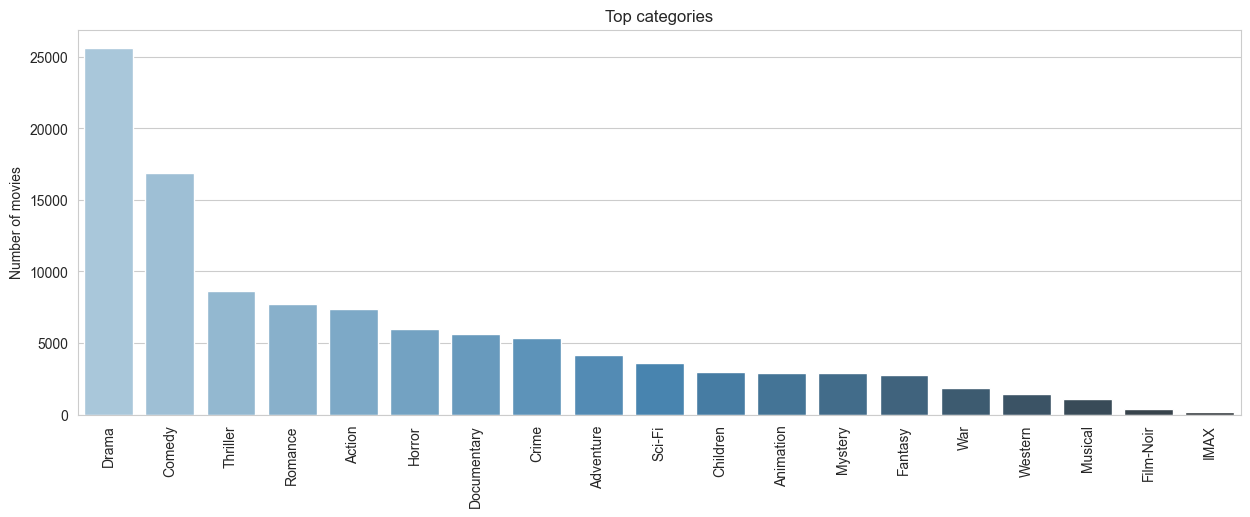

In [14]:
#Top categories
dftmp = movies.drop(['movieId', 'title', 'year', '(no genres listed)'], axis=1)

genres = genres[:-1]
categories = {}
for genre in genres.genre:
    categories[genre] = dftmp[genre].sum()

# Sorting categories by descending order
categories = sorted(categories.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(15, 5))
ax = sns.barplot(x=[x[0] for x in categories], y=[x[1] for x in categories], palette='Blues_d')
ax.set_ylabel('Number of movies')
plt.xticks(rotation=90)
plt.title('Top categories')
plt.show()

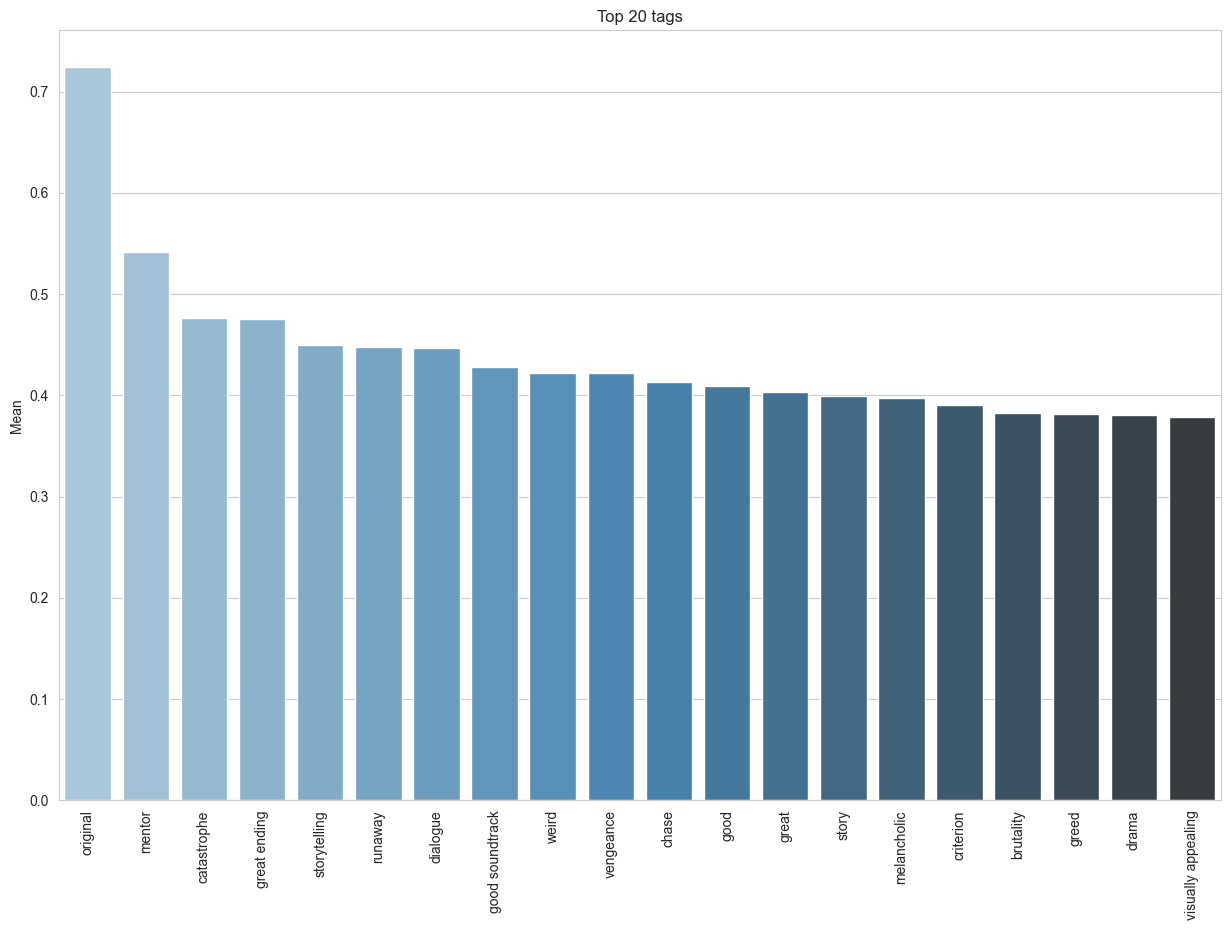

In [15]:
# Top tags
dftmp = df_no_genres.drop(['rating_mean', 'rating_count'], axis=1)

tags = list(dftmp.columns)
data = {}
for tag in tags:
    data[tag] = dftmp[tag].mean()

# Sorting tags by descending order
data = sorted(data.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(15, 10))
ax = sns.barplot(x=[x[0] for x in data[:20]], y=[x[1] for x in data[:20]], palette='Blues_d')
ax.set_ylabel('Mean')
plt.xticks(rotation=90)
plt.title('Top 20 tags')
plt.show()

### Correlation and Covariance between ratings and genres

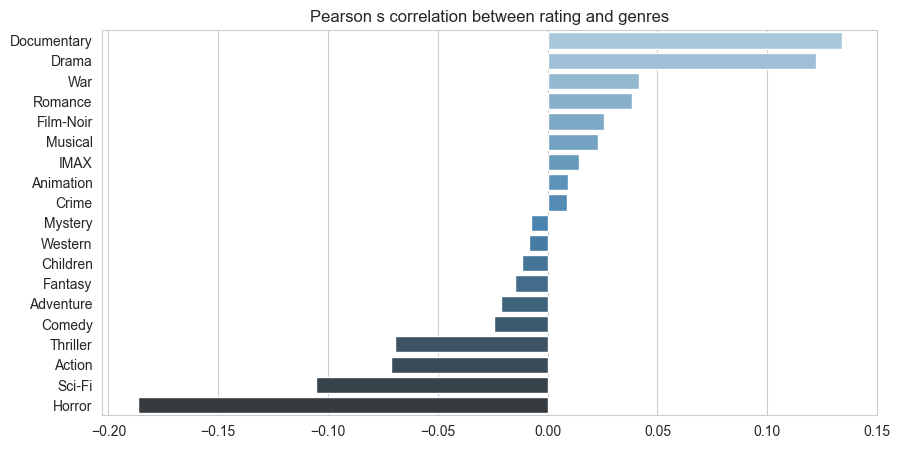

In [16]:
dftmp = movies.merge(ratings, on='movieId')
dftmp = dftmp.drop(['movieId', 'title', 'year', 'rating_count', '(no genres listed)'], axis=1)

correlation = dftmp.corr(method='pearson')
correlation = correlation['rating_mean'].sort_values(ascending=False)
correlation = correlation[1:]

plt.figure(figsize=(10, 5))
sns.barplot(x=correlation.values, y=correlation.index, palette='Blues_d')
plt.title('Pearson s correlation between rating and genres')
plt.show()

# Non so se ha senso
covariance = dftmp.cov()
covariance = covariance['rating_mean'].sort_values(ascending=False)
covariance = covariance[1:]

plt.figure(figsize=(10, 5))
sns.barplot(x=covariance.values, y=covariance.index)
plt.title('Covariance between rating and genres')
plt.show()

### Correlation and Covariance between ratings and tags

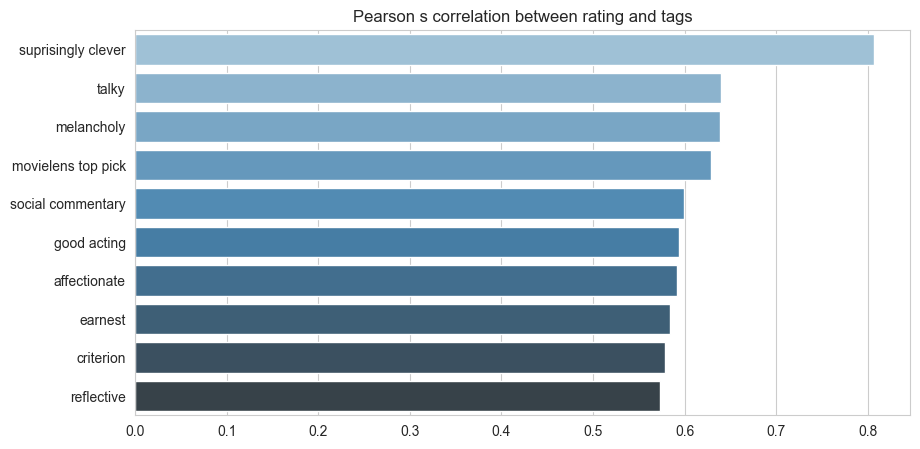

In [21]:
# Correlation between ratings and tags
dftmp = df_no_genres.drop(['rating_count'], axis=1)

correlation = dftmp.corr(method='pearson')
correlation = correlation['rating_mean'].sort_values(ascending=False)
correlation = correlation[1:]

plt.figure(figsize=(10, 5))
sns.barplot(x=correlation.values[:10], y=correlation.index[:10], palette='Blues_d')
plt.title('Pearson s correlation between rating and tags')
plt.show()